In [1]:
import os
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# helper functions

def add_shift(series):
    scale_factor = 0.2
    for key in series:
        if (key[-1] != 'z' and key[-1] != 'v'):
            rand_num = np.random.rand() * scale_factor - (scale_factor / 2)
            series[key] = [x + rand_num for x in series[key]]
    return series

def add_noise(series):
    scale_factor = 0.05
    for key in series:
        if (key[-1] != 'z' and key[-1] != 'v'):
            rand_num = np.random.rand() * scale_factor - (scale_factor / 2)
            series[key] = [x + (np.random.rand() * scale_factor - (scale_factor / 2)) for x in series[key]]
    return series

def rand_augment(series):
    series = add_shift(series)
    series = add_noise(series)
    return series


def series_append(series, list, keys):
    for i in range(64):
        series[keys[i]].append(float(list[i]))
    return series

def load_series(filename):
    with open(filename, 'r') as csv_in:
        csv_file = list(csv.reader(csv_in))
        series = {}
        keys = csv_file[0]
        for key in keys: series[key] = []
        for i in range(2, len(csv_file), 2):
            series = series_append(series, csv_file[i], keys)
        return [series, int((len(csv_file) - 2) / 2)]


def make_2D(series):
    l = []
    for key in series:
        if (key[-1] == 'v' or key[-1] == 'z'): continue
        key_list = []
        for e in series[key]:
            key_list.append([e]) # try brackets here
        l.append(key_list)
    return l

def E3(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= (7.0/18.0)):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E2(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= (5.0/18.0)):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E1(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= (3.0/18.0)):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E0(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= (1.0/18.0)):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def eval(pred, truth):
    o_pred = []
    o_truth = []
    f_pred = []
    f_truth = []
    b_pred = []
    b_truth = []
    s_pred = []
    s_truth = []
    l_pred = []
    l_truth = []
    for p in pred:
        o_pred.append(p[0])
        f_pred.append(p[1])
        b_pred.append(p[2])
        s_pred.append(p[3])
        l_pred.append(p[4])
    for t in truth:
        o_truth.append(t[0])
        f_truth.append(t[1])
        b_truth.append(t[2])
        s_truth.append(t[3])
        l_truth.append(t[4])
    return [[E0(o_pred, o_truth), E1(o_pred, o_truth), E2(o_pred, o_truth), E3(o_pred, o_truth)],
            [E0(f_pred, f_truth), E1(f_pred, f_truth), E2(f_pred, f_truth), E3(f_pred, f_truth)],
            [E0(b_pred, b_truth), E1(b_pred, b_truth), E2(b_pred, b_truth), E3(b_pred, b_truth)],
            [E0(s_pred, s_truth), E1(s_pred, s_truth), E2(s_pred, s_truth), E3(s_pred, s_truth)],
            [E0(l_pred, l_truth), E1(l_pred, l_truth), E2(l_pred, l_truth), E3(l_pred, l_truth)]]

In [63]:
''' https://github.com/HobbitLong/SupContrast/blob/master/losses.py '''

class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-6)

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask*log_prob).sum(1)/(mask.sum(1)+1e-6)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [97]:
# setting up CNN

conv_1 = 32
conv_2 = 64
conv_3 = 128
conv_4 = 256

fc_size1 = 256
fc_size2 = 512
fc_size3 = 256
fc_size4 = 128
fc_size5 = 64
output_size = 2
batch_size = 371
learning_rate = 0.01
tmp = 0.07

bsz = 464
    

class SiameseNet(nn.Module):

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(0.1)

    def __init__(self):
        super(SiameseNet, self).__init__()
        self.apply(self._init_weights)
        # conv layers
        self.conv1 = nn.Conv2d(conv_1, conv_2, (1,3), stride=1)
        self.conv2 = nn.Conv2d(conv_2, conv_3, (1,3), stride=1)
        self.conv3 = nn.Conv2d(conv_3, conv_4, (1,3), stride=1)
        # fc layers
        self.fc1 = nn.Linear(fc_size1, fc_size2)
        self.fc2 = nn.Linear(fc_size2, fc_size3)
        self.fc3 = nn.Linear(fc_size3, fc_size4)
        self.fc4 = nn.Linear(fc_size4, fc_size5)
        self.fc5 = nn.Linear(fc_size5, output_size)
        # sigmoid
    
    def forward(self, x):
        # convolutions
        x = F.leaky_relu(self.conv1(x), negative_slope=0.1)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.1)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.1)

        #print('AFTER CONV: ' + str(x.size()))

        x = torch.flatten(x, 0)

        x = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc4(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc5(x), negative_slope=0.1)

        x = F.normalize(x, p=2, dim=0)

        return x

model = SiameseNet()

loss_function = SupConLoss(temperature=tmp)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [103]:
# loading data into 2 views

dir = '..\\time_series\\Time_normalized_stages\\4_final\\'

n_views = 2

orig_x = []
labels = []
X_train = []

for file in os.listdir(dir):
    series, num_frames = load_series(dir + file)
    labels.append(float(file[4]) / 9)
    orig_x.append(series)

for example in orig_x:
    x1 = make_2D(rand_augment(example))
    x2 = make_2D(rand_augment(example))
    X_train.append([x1, x2])

X_train = torch.tensor(X_train)

for example in X_train:
    print(example)

print(torch.tensor(X_train).size())

list_features = [[model(torch.tensor(ex).permute(0, 2, 1)) for ex in pair] for pair in X_train]
features = torch.Tensor(bsz, n_views, output_size)
#print(list_features)

for pair in list_features:
    print(pair)
    torch.cat(features, pair)
    break

torch.cat(list_features, out=features)

features = torch.cat(torch.unsqueeze(features, dim=0))
print(features.size())

labels = torch.tensor(labels)
print(labels.size())

print(loss_function(features, labels))


tensor([[[[-0.0846],
          [ 0.1249],
          [ 0.1383],
          [-0.0130],
          [-0.0383],
          [-0.1068],
          [-0.0843]],

         [[ 1.4257],
          [ 1.3743],
          [ 1.3540],
          [ 1.3136],
          [ 1.3860],
          [ 1.4245],
          [ 1.3701]],

         [[ 0.2389],
          [ 0.1523],
          [ 0.1019],
          [ 0.0904],
          [ 0.1658],
          [-0.0053],
          [-0.0760]],

         [[ 1.4192],
          [ 1.3466],
          [ 1.2697],
          [ 1.3028],
          [ 1.3516],
          [ 1.4078],
          [ 1.3599]],

         [[-0.2228],
          [ 0.0923],
          [ 0.1735],
          [-0.0987],
          [-0.2377],
          [-0.3077],
          [-0.0677]],

         [[ 0.9263],
          [ 0.8873],
          [ 0.8746],
          [ 0.9050],
          [ 1.0417],
          [ 1.1093],
          [ 0.9160]],

         [[ 0.1216],
          [-0.0656],
          [-0.2405],
          [-0.0648],
          [ 0.1108],
 

KeyboardInterrupt: 

0
tensor(6.1377)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

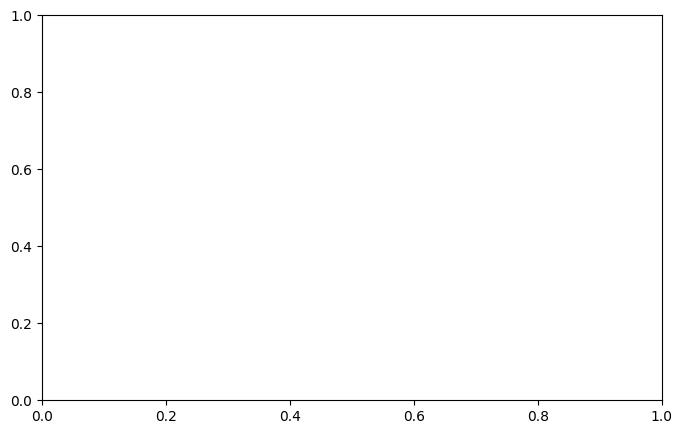

In [76]:
num_epochs = 100
losses = []
fig, ax = plt.subplots(1, figsize=(8,5))

for epoch in range(num_epochs):
    model.train()
    print(epoch)
    result = model(orig_x)
    features = torch.tensor([[x] for x in results.tolist()])
    loss = loss_function(features, labels)
    print(loss)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

ax.plot(losses)
